In [1]:
import math
import os
import pickle
import re
import time
from datetime import datetime, timedelta, timezone
from functools import partial
from pathlib import Path

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import spacy
import tensorflow
import tweepy
from feature_engine.creation import CyclicalFeatures
from gensim import corpora, models
from gensim.models import CoherenceModel
from germansentiment import SentimentModel
from googletrans import Translator

# from gsdmm import MovieGroupProcess
from nltk.tokenize import word_tokenize
from nrclex import NRCLex
from sklearn.feature_extraction.text import CountVectorizer
from spacy_langdetect import LanguageDetector
from statsmodels.stats.stattools import medcouple
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from unidecode import unidecode
from scipy.stats import lognorm
from utils import get_tweepy_client

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Version 1

In [37]:
tweets_df = pd.read_csv("all_tweets.csv", index_col=0)
tweets_df.head(3)

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_11894/971841145.py:1: DtypeWarning: Columns (15,26) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv("all_tweets.csv", index_col=0)


,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21+00:00,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27+00:00,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09+00:00,[1617597571903676417],1617597571903676417,NaN,tr,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,True


In [38]:
tweets_df.shape

(359036, 28)

# Version 2

## What is done

1. Gender of the author is added to each tweet
2. Profession of the author is added to each tweet
3. Hashtags are extracted from a dictionary values and joined with comma into `hashtags_flattened` column
4. Existence of trend topics are extracted and two related columns are added.

In [2]:
users_df = pd.read_excel("HRA Twitter Accounts.xlsx")
users_df = users_df[users_df.valid == 1]
users_df.head(3)

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_11894/2019825818.py:1: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC])
  users_df = pd.read_excel("HRA Twitter Accounts.xlsx")


,full_name,screen_name,method_to_find,comment,valid,location,name,created_at,description,verified,followers_count,following_count,tweet_count,id,gender,profession,age_of_account_in_days,Unnamed: 17,Unnamed: 18
0,Akın Birdal,akin_birdal,web-search,NaN,1,NaN,Akın Birdal,2013-04-14 16:39:04+00:00,NaN,False,80216.0,786.0,2937.0,1.352279e+09,M,UNKNOWN,3578.0,NaN,NaN
2,Cemil Çiçek,avcemilcicek,well-known,NaN,1,"Çankaya, Ankara",Cemil Çiçek,2011-07-20 11:49:01+00:00,Hukukçu/Law - @ASBUedu Asian Studies MA | Ceza...,False,112011.0,1361.0,14618.0,3.389775e+08,M,LAWYER,4212.0,NaN,NaN
4,Ayşe Gül Altınay,aysealtinay,web-search,NaN,1,Istanbul,Ayşe Gül Altınay,2010-11-28 23:09:32+00:00,NaN,False,6883.0,2519.0,10187.0,2.208243e+08,F,UNKNOWN,4445.0,NaN,NaN


In [22]:
# Gender and Profession is added
tweets_df_v2 = pd.merge(
    tweets_df,
    users_df[["screen_name", "gender", "profession"]],
    left_on="author",
    right_on="screen_name",
)
tweets_df_v2.created_at = pd.to_datetime(
    tweets_df_v2.created_at, format="%Y-%m-%d %H:%M:%S+00:00"
)
tweets_df_v2.drop(columns=["screen_name"], inplace=True)
tweets_df_v2.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender,profession
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False,ORG,NOT AVAILABLE
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False,ORG,NOT AVAILABLE
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,tr,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,True,ORG,NOT AVAILABLE


In [23]:
# adding a column with all hashtags as strings
lst_hashtags = []

for i in tqdm(tweets_df_v2["hashtags"]):
    if type(i) == float and math.isnan(i):
        lst_hashtags.append("")
    else:
        hashtags = ", ".join([j["tag"] for j in eval(i)])
        lst_hashtags.append(hashtags)

tweets_df_v2["hashtags_flattened"] = lst_hashtags
tweets_df_v2.head(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359036/359036 [00:00<00:00, 376713.67it/s]


,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender,profession,hashtags_flattened
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur


In [24]:
df_all_trends = pd.read_csv("df_all_trends.csv")
df_all_trends["date"] = pd.to_datetime(df_all_trends["date"], format="%d-%m-%Y")
df_all_trends["trend_topic"] = df_all_trends["trend_topic"].str.replace("#", "")
df_all_trends.head()

,time,trend_topic,date
0,00:10,Zamlar,2022-01-01
1,00:10,2022NewYear,2022-01-01
2,00:10,elektrik,2022-01-01
3,00:10,BurasıislamDevleti,2022-01-01
4,00:10,millipiyango,2022-01-01


In [25]:
df_all_trends = df_all_trends[["date", "trend_topic"]].drop_duplicates()
df_all_trends.head(3)

,date,trend_topic
0,2022-01-01,Zamlar
1,2022-01-01,2022NewYear
2,2022-01-01,elektrik


In [26]:
tweets_df_v2.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender,profession,hashtags_flattened
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur


In [27]:
def generate_trend_topic_columns(row):
    trend_topics_in_two_weeks = df_all_trends[
        df_all_trends.date.isin(
            [(row.created_at - timedelta(days=i - 7)).date() for i in range(15)]
        )
    ].trend_topic.to_list()
    trend_topics_in_tweet = [
        hashtag
        for hashtag in row.hashtags_flattened.split(", ")
        if hashtag in trend_topics_in_two_weeks
    ]
    return pd.Series(
        {
            "trend_topics_in_tweet": ", ".join(trend_topics_in_tweet),
            "n_trend_topics": len(trend_topics_in_tweet),
        }
    )


tweets_df_v2[["trend_topics", "n_trend_topics"]] = tweets_df_v2.apply(
    generate_trend_topic_columns, axis=1
)

In [28]:
tweets_df_v2.to_csv("all_tweets_v2.csv", line_terminator="\r\n")

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_1139/540208934.py:1: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  tweets_df_v2.to_csv("all_tweets_v2.csv", line_terminator='\r\n')


# Version 3

## What is done

1. Feature Engineering related to replies, retweets, existence of the media etc.

In [42]:
tweets_df_v3 = pd.read_csv("all_tweets_v2.csv", index_col=0, low_memory=False)

In [ ]:
tweets_df_v3["text_length"] = tweets_df_v3["text"].apply(
    lambda x: len(x) if type(x) is str else np.nan
)
tweets_df_v3["has_media"] = np.where(tweets_df_v3["media_keys"].isna(), 0, 1)
tweets_df_v3["has_hashtags"] = np.where(tweets_df_v3["hashtags"].isna(), 0, 1)
tweets_df_v3["has_mentions"] = np.where(tweets_df_v3["mentions"].isna(), 0, 1)
tweets_df_v3["is_retweet"] = tweets_df_v3["is_retweet"].astype(int)
tweets_df_v3["is_reply"] = np.where(tweets_df_v3["in_reply_to_user_id"].isna(), 0, 1)
tweets_df_v3.rename(
    columns={"gender": "gender_of_author", "profession": "profession_of_author"},
    inplace=True,
)
tweets_df_v3["tweet_type"] = np.where(
    tweets_df_v3["is_reply"] == 1,
    "only_reply",
    np.where(
        tweets_df_v3["is_retweet"] == 1, "only_retweet", "no_reply_and_no_retweet"
    ),
)
tweets_df_v3["ratio_like"] = (
    tweets_df_v3["like_count"] / tweets_df_v3["impression_count"]
)
tweets_df_v3["ratio_retweet"] = (
    tweets_df_v3["retweet_count"] / tweets_df_v3["impression_count"]
)
tweets_df_v3.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231


In [44]:
tweets_df_v3.to_csv("all_tweets_v3.csv", lineterminator="\r\n")

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_1139/2190460596.py:1: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  tweets_df_v3.to_csv("all_tweets_v3.csv", line_terminator='\r\n')


# Version 4

### What is done

1. Include botometer results in each tweet
2. Include author features such as n_followers, n_tweets etc.

In [56]:
tweets_df_v4 = pd.read_csv("all_tweets_v3.csv", index_col=0, low_memory=False)

In [57]:
bot_df = pd.DataFrame(
    columns=[
        "author",
        "majority_lang",
        "english",
        "universal",
        "eng_astroturf",
        "eng_fake_follower",
        "eng_financial",
        "eng_other",
        "eng_overall",
        "eng_self_declared",
        "eng_spammer",
        "uni_astroturf",
        "uni_fake_follower",
        "uni_financial",
        "uni_other",
        "uni_overall",
        "uni_self_declared",
        "uni_spammer",
    ]
)

for i in tqdm(os.listdir("users_botometer/")):
    with open(f"users_botometer/{i}", "rb") as f:
        bot_col = pickle.load(f)

    bot_feat = [
        bot_col["user"]["user_data"]["screen_name"],
        bot_col["user"]["majority_lang"],
        bot_col["cap"]["english"],
        bot_col["cap"]["universal"],
        bot_col["raw_scores"]["english"]["astroturf"],
        bot_col["raw_scores"]["english"]["fake_follower"],
        bot_col["raw_scores"]["english"]["financial"],
        bot_col["raw_scores"]["english"]["other"],
        bot_col["raw_scores"]["english"]["overall"],
        bot_col["raw_scores"]["english"]["self_declared"],
        bot_col["raw_scores"]["english"]["spammer"],
        bot_col["raw_scores"]["universal"]["astroturf"],
        bot_col["raw_scores"]["universal"]["fake_follower"],
        bot_col["raw_scores"]["universal"]["financial"],
        bot_col["raw_scores"]["universal"]["other"],
        bot_col["raw_scores"]["universal"]["overall"],
        bot_col["raw_scores"]["universal"]["self_declared"],
        bot_col["raw_scores"]["universal"]["spammer"],
    ]

    bot_df.loc[len(bot_df)] = bot_feat

bot_df.head(2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 1257.57it/s]


,author,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer
0,mlsaturkey,tr,0.796828,0.721951,0.10,0.10,0.0,0.47,0.46,0.02,0.00,0.07,0.02,0.0,0.25,0.21,0.00,0.00
1,EnesFreedom,en,0.794672,0.799570,0.07,0.05,0.0,0.22,0.40,0.03,0.05,0.09,0.01,0.0,0.29,0.36,0.02,0.09


In [58]:
tweets_df_v4 = pd.merge(tweets_df_v4, bot_df, on="author")
tweets_df_v4.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16


In [93]:
users_df.head(2)

,full_name,screen_name,method_to_find,comment,valid,location,name,created_at,description,verified,followers_count,following_count,tweet_count,id,gender,profession,age_of_account_in_days,Unnamed: 17,Unnamed: 18
0,Akın Birdal,akin_birdal,web-search,NaN,1,NaN,Akın Birdal,2013-04-14 16:39:04+00:00,NaN,False,80216.0,786.0,2937.0,1.352279e+09,M,UNKNOWN,3578.0,NaN,NaN
2,Cemil Çiçek,avcemilcicek,well-known,NaN,1,"Çankaya, Ankara",Cemil Çiçek,2011-07-20 11:49:01+00:00,Hukukçu/Law - @ASBUedu Asian Studies MA | Ceza...,False,112011.0,1361.0,14618.0,3.389775e+08,M,LAWYER,4212.0,NaN,NaN


In [95]:
columns_to_merge = [
    "screen_name",
    "verified",
    "followers_count",
    "following_count",
    "tweet_count",
    "age_of_account_in_days",
]
tweets_df_v4 = pd.merge(
    tweets_df_v4, users_df[columns_to_merge], left_on="author", right_on="screen_name"
)
tweets_df_v4.rename(
    columns={column: f"{column}_author" for column in columns_to_merge}, inplace=True
)
tweets_df_v4.drop(columns=["screen_name_author"], inplace=True)
tweets_df_v4.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0


In [96]:
tweets_df_v4.to_csv("all_tweets_v4.csv", lineterminator="\r\n")

# Version 5

1. Sentiment Analysis from tweets

In [2]:
tweets_df_v5 = pd.read_csv("all_tweets_v4.csv", index_col=0, low_memory=False)
tweets_df_v5.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0


In [84]:
def get_sa_model_by_name(model_name, from_tf: bool = False):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, from_tf=from_tf
    )
    return pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)


model_zoo = {
    "tr": get_sa_model_by_name("savasy/bert-base-turkish-sentiment-cased"),
    "en": get_sa_model_by_name("cardiffnlp/twitter-roberta-base-sentiment"),
    "fr": get_sa_model_by_name("tblard/tf-allocine", from_tf=True),
    "de": SentimentModel(),
}

All TF 2.0 model weights were used when initializing CamembertForSequenceClassification.

All the weights of CamembertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use CamembertForSequenceClassification for predictions without further training.


In [89]:
def preprocess_tweet_text_for_english(text):
    new_text = []
    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)


def predict_sentiment_with_de_model(model, row):
    labels, probabilities = model.predict_sentiment(
        [row.text], output_probabilities=True
    )
    label = labels[0]
    assert label in ["negative", "positive", "neutral"], row
    if label == "neutral":
        return 0
    else:
        score = {prob[0]: prob[1] for prob in probabilities[0]}[label]
        return score if label == "positive" else -score


def predict_sentiment_with_en_model(model, row):
    text = preprocess_tweet_text_for_english(row.text)
    sentiment_result = model(text)[0]
    assert sentiment_result["label"] in ["LABEL_0", "LABEL_1", "LABEL_2"], row
    if sentiment_result["label"] == "LABEL_1":
        return 0
    return (
        -sentiment_result["score"]
        if sentiment_result["label"] == "LABEL_0"
        else sentiment_result["score"]
    )


def predict_sentiment_with_fr_and_tr_model(model, row):
    sentiment_result = model(row.text)[0]
    assert sentiment_result["label"].lower() in ["positive", "negative"], row
    return (
        -sentiment_result["score"]
        if sentiment_result["label"].lower() == "NEGATIVE"
        else sentiment_result["score"]
    )


def predict_sentiment(row):
    if model := model_zoo.get(row.lang):
        if row.lang == "de":
            return predict_sentiment_with_de_model(model, row)
        elif row.lang == "en":
            return predict_sentiment_with_en_model(model, row)
        else:
            return predict_sentiment_with_fr_and_tr_model(model, row)
    else:
        return np.nan

In [91]:
s = time.time()
tweets_df_v5["sentiment"] = tweets_df_v5.apply(predict_sentiment, axis=1)
print(f"Total elapsed time in seconds: {time.time() - s}")

Total elapsed time in seconds: 14573.041397094727
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [95]:
tweets_df_v5.to_csv("all_tweets_v5.csv", lineterminator="\r\n")

# Version 6

### What is done

1. Create datetime features.
    - created_at_day_of_week
    - created_at_month_of_year
    - created_at_time_of_day_in_seconds
2. Create ratio variables.
    - reply to tweet ratio
    - retweet to tweet ratio
    - average tweets per day per user

In [126]:
tweets_df_v6 = pd.read_csv("all_tweets_v5.csv", index_col=0, low_memory=False)
tweets_df_v6.created_at = pd.to_datetime(
    tweets_df_v6.created_at, format="%Y-%m-%d %H:%M:%S"
)
tweets_df_v6.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746


In [127]:
tweets_df_v6["created_at_day_of_week"] = tweets_df_v6["created_at"].dt.day_of_week
tweets_df_v6["created_at_month_of_year"] = tweets_df_v6["created_at"].dt.month
tweets_df_v6["created_at_time_of_day_in_seconds"] = tweets_df_v6["created_at"].apply(
    lambda x: (x - x.replace(hour=0, minute=0, second=0, microsecond=0)).seconds
)

In [128]:
tweets_df_v6.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307


In [129]:
# Create reply to tweet ratio per user
nr_tweets_per_user = tweets_df_v6.author.value_counts()
nr_replies_per_user = tweets_df_v6[tweets_df_v6.is_reply == 1].author.value_counts()
reply_to_tweet_ratio_per_user = nr_replies_per_user / nr_tweets_per_user
reply_to_tweet_ratio_per_user = (
    reply_to_tweet_ratio_per_user.to_frame()
    .reset_index()
    .rename(columns={"index": "author", "author": "reply_to_tweet_ratio"})
)
tweets_df_v6 = pd.merge(tweets_df_v6, reply_to_tweet_ratio_per_user, on="author")
tweets_df_v6.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,99,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.000000,0,1,68289,0.013817
3,1449804331142811655,NaN,1617597543000440844,2023-01-23 18:58:02,[1617597543000440844],1617597543000440844,NaN,de,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,Goksun_KHK,NaN,NaN,1,1,1,0,86,['3_1617597534494392354'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.011628,0.011628,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,-0.599463,0,1,68282,0.013817
4,1449804331142811655,NaN,1617597477963829248,2023-01-23 18:57:46,[1617597477963829248],1617597477963829248,NaN,tr,False,[<ReferencedTweet id=1617597368417013761 type=...,everyone,RT @Malatya_KHK: Öldükten sonra insanlari işe ...,Goksun_KHK,NaN,NaN,0,4,0,0,0,NaN,NaN,"[{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 15, 'username': 'Malatya_...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,82,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87

In [130]:
# Create retweet to tweet ratio per user
nr_retweets_per_user = tweets_df_v6[tweets_df_v6.is_retweet == 1].author.value_counts()
retweet_to_tweet_ratio_per_user = nr_retweets_per_user / nr_tweets_per_user
retweet_to_tweet_ratio_per_user = (
    retweet_to_tweet_ratio_per_user.to_frame()
    .reset_index()
    .rename(columns={"index": "author", "author": "retweet_to_tweet_ratio"})
)
tweets_df_v6 = pd.merge(tweets_df_v6, retweet_to_tweet_ratio_per_user, on="author")
tweets_df_v6.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,99,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.000000,0,1,68289,0.013817,0.435233
3,1449804331142811655,NaN,1617597543000440844,2023-01-23 18:58:02,[1617597543000440844],1617597543000440844,NaN,de,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,Goksun_KHK,NaN,NaN,1,1,1,0,86,['3_1617597534494392354'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.011628,0.011628,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,-0.599463,0,1,68282,0.013817,0.435233
4,1449804331142811655,NaN,1617597477963829248,2023-01-23 18:57:46,[1617597477963829248],1617597477963829248,NaN,tr,False,[<ReferencedTweet id=1617597368417013761 type=...,everyone,RT @Malatya_KHK: Öldükten sonra insanlari işe ...,Goksun_KHK,NaN,NaN,0,4,0,0,0,NaN,NaN,"[{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 15, 'username': 'Malatya_...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,82,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463

In [131]:
# Average tweets per day per user
average_tweets_per_day_per_user = (
    nr_tweets_per_user
    / users_df[["screen_name", "age_of_account_in_days"]]
    .rename(columns={"screen_name": "author"})
    .set_index("author")
    .squeeze()
)
average_tweets_per_day_per_user = (
    average_tweets_per_day_per_user.to_frame()
    .reset_index()
    .rename(columns={"index": "author", 0: "average_tweets_of_author_per_day"})
)
tweets_df_v6 = pd.merge(tweets_df_v6, average_tweets_per_day_per_user, on="author")
tweets_df_v6.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,99,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.000000,0,1,68289,0.013817,0.435233,1.231915
3,1449804331142811655,NaN,1617597543000440844,2023-01-23 18:58:02,[1617597543000440844],1617597543000440844,NaN,de,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,Goksun_KHK,NaN,NaN,1,1,1,0,86,['3_1617597534494392354'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.011628,0.011628,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,-0.599463,0,1,68282,0.013817,0.435233,1.231915
4,1449804331142811655,NaN,1617597477963829248,2023-01-23 18:57:46,[1617597477963829248],1617597477963829248,NaN,tr,False,[<ReferencedTweet id=1617597368417013761 type=...,everyone,RT @Malatya_KHK: Öldükten sonra insanlari işe ...,Goksun_KHK,NaN,NaN,0,4,0,0,0,NaN,NaN,"[{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 15, 'username': 'Malatya_...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisy

In [133]:
tweets_df_v6.shape

(359036, 70)

In [134]:
tweets_df_v6.to_csv("all_tweets_v6.csv", lineterminator="\r\n")

# Version 7

### What is done

1. RT prefix for the text of retweets is stripped.

In [15]:
tweets_df_v7 = pd.read_csv("all_tweets_v6.csv", index_col=0, low_memory=False)
tweets_df_v7.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915


In [16]:
tweets_df_v7.text = tweets_df_v7.text.str.lstrip("RT ")

In [17]:
tweets_df_v7.to_csv("all_tweets_v7.csv", lineterminator="\r\n")

# Version 8

### What is done

1. Include media features from twitter API

In [57]:
tweets_df_v8 = pd.read_csv("all_tweets_v7.csv", index_col=0, low_memory=False)
tweets_df_v8["media_keys"] = tweets_df_v8.media_keys.apply(
    lambda x: eval(x) if type(x) == str else x
)
tweets_df_v8.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915


In [3]:
tweepy_client = get_tweepy_client()

TWEEPY client is successfully created...


In [4]:
df_media = tweets_df_v8[tweets_df_v8.has_media == 1]
df_media.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915
3,1449804331142811655,NaN,1617597543000440844,2023-01-23 18:58:02,[1617597543000440844],1617597543000440844,NaN,de,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,Goksun_KHK,NaN,NaN,1,1,1,0,86,['3_1617597534494392354'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.011628,0.011628,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,-0.599463,0,1,68282,0.013817,0.435233,1.231915


In [5]:
tweet_ids = df_media.id.to_list()
tweets_ids_in_100_batch = [
    tweet_ids[i * 100 : (i + 1) * 100] for i in range(df_media.shape[0] // 100 + 1)
]

df_media.shape, len(tweets_ids_in_100_batch), len(tweets_ids_in_100_batch[0]), sum(
    len(i) for i in tweets_ids_in_100_batch
)

((58668, 70), 587, 100, 58668)

In [7]:
raw_media_features = []
for i, tweet_ids in tqdm(
    enumerate(tweets_ids_in_100_batch), total=len(tweets_ids_in_100_batch)
):
    retry_count = 0
    while retry_count < 10:
        try:
            tweets = tweepy_client.get_tweets(
                tweet_ids,
                expansions="attachments.media_keys",
                media_fields="duration_ms,height,media_key,preview_image_url,public_metrics,type,url,width,alt_text",
            )
            break
        except (
            tweepy.errors.TweepyException,
            requests.exceptions.ConnectionError,
        ) as e:
            retry_count += 1
            if retry_count >= 10:
                raise e
            print(
                f"Received TweepyException Error, retrying one more time: retry count {retry_count}. \n\n Error: {e}"
            )
            time.sleep(1)

    for j, media in enumerate(tweets.includes["media"]):
        raw_media_features.append(dict(media))

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 300/587 [03:04<02:21,  2.02it/s]Rate limit exceeded. Sleeping for 721 seconds.


Received TweepyException Error, retrying one more time: retry count 1. 

 Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [18:28<00:00,  1.89s/it]


In [61]:
tweets_df_v8.media_keys.apply(lambda x: len(x) if type(x) == list else 0).unique()

array([0, 1, 2, 4, 3])

In [50]:
raw_media_features_df = pd.DataFrame(raw_media_features)
raw_media_features_df.head()

,media_key,type,height,url,width,public_metrics,preview_image_url,duration_ms,alt_text
0,3_1617597636604723228,photo,1600,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600,NaN,NaN,NaN,NaN
1,3_1617597534494392354,photo,1600,https://pbs.twimg.com/media/FnLcYyEWACIc5jQ.jpg,1600,NaN,NaN,NaN,NaN
2,3_1617597418895179790,photo,1600,https://pbs.twimg.com/media/FnLcSDbWAA4b6BW.jpg,1600,NaN,NaN,NaN,NaN
3,3_1617597294852833284,photo,1600,https://pbs.twimg.com/media/FnLcK1VWAAQM14n.jpg,1600,NaN,NaN,NaN,NaN
4,3_1617597176913199135,photo,1600,https://pbs.twimg.com/media/FnLcD9-WAB8KXIW.jpg,1600,NaN,NaN,NaN,NaN


In [65]:
tweets_df_v8.media_keys.head()

0                        NaN
1    [3_1617597636604723228]
2                        NaN
3    [3_1617597534494392354]
4                        NaN
Name: media_keys, dtype: object

In [75]:
media_columns = [
    f"media_{c}_{i}" for i in range(1, 5) for c in raw_media_features_df.columns
]

for c in media_columns:
    tweets_df_v8[c] = np.nan

tweets_df_v8.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,@Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇünkü ...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,99,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.000000,0,1,68289,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1449804331142811655,NaN,1617

In [89]:
tweets_df_v8.loc[i, f"media_{feature}_{j+1}"] = feature_value.get("view_count")

In [94]:
for i, row in tqdm(tweets_df_v8.iterrows(), total=tweets_df_v8.shape[0]):
    if type(row.media_keys) == list:
        for j, media_key in enumerate(row.media_keys):
            filtered_media_row = raw_media_features_df[
                raw_media_features_df.media_key == media_key
            ]
            if filtered_media_row.shape[0]:
                raw_media_feature = filtered_media_row.iloc[0].to_dict()
                for feature, feature_value in raw_media_feature.items():
                    if type(feature_value) == dict:
                        assert len(feature_value) == 1, feature_value
                        feature_value = feature_value.get("view_count")
                    tweets_df_v8.loc[i, f"media_{feature}_{j+1}"] = feature_value

In [95]:
tweets_df_v8.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,no_reply_and_no_retweet,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,no_reply_and_no_retweet,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449804331142811655,NaN,1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,everyone,@Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇünkü ...,Goksun_KHK,NaN,NaN,0,48,0,0,0,NaN,NaN,"[{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...",NaN,"[{'start': 3, 'end': 14, 'username': 'Yozgat_K...",NaN,NaN,1,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,99,0,1,1,0,only_retweet,NaN,inf,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.000000,0,1,68289,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [96]:
tweets_df_v8.to_pickle("all_tweets_v8.pkl")

# Version 9

### What is done

1. Insert STTM predictions to the tweets

In [77]:
tweets_df_v9 = pd.read_pickle("all_tweets_v8.pkl")

In [78]:
stopwords = nltk.corpus.stopwords.words("turkish")
stopwords = [unidecode(i) for i in stopwords]

with open("models/gsdmm_model_with_K_19", "rb") as fb:
    sttm_model = pickle.load(fb)

cluster_to_meaning_mapping = {
    18: "decree-law",
    11: "search for justice",
    15: "dismissal of governmental workers",
    9: "irrelevant tweets",
    0: "injustice against children",
    8: "expressing wishes",
    2: "politics",
    13: "woman rights",
    14: "invitation, agenda declaration",
    5: "death, torture, suicide",
    16: "democracy",
    17: "inflation, financial instability",
    12: "supreme court",
    7: "freedom of speech",
    1: "vulnerable, sick people",
    4: "internatial relations",
    3: "Uyghurs",
    10: "lost people",
    6: "activism for nature",
}


def get_sttm_topic(row):
    if row.lang != "tr":
        return row.lang
    else:
        # preprocessing
        tweet_text = row.text
        tweet_text = tweet_text.lower()
        tweet_text = re.sub("\n", " ", tweet_text)
        tweet_text = re.sub("#(\w+)[^\w]", " ", tweet_text)  # remove hashtag
        tweet_text = re.sub("@([A-Za-z0-9_]+)", " ", tweet_text)  # remove mentions
        tweet_text = re.sub("https://t.co/[A-Za-z0-9]+", " ", tweet_text)  # remove link
        tweet_text = re.sub("\b\w*khk\w*\b", " ", tweet_text)  # normalise khk words
        tweet_text = tweet_text.replace("[^\w\s]", "")
        tweet_text = unidecode(tweet_text)  # remove accents
        tweet_text = " ".join(
            [word for word in tweet_text.split() if word not in (stopwords)]
        )
        if len(tweet_text) <= 5:
            return "too_short_tweet"
        tokenized_tweet_text = word_tokenize(tweet_text)

        topic_probabilities = sttm_model.score(tokenized_tweet_text)
        topic_index = np.argmax(topic_probabilities)
        assert topic_index != sttm_model.K

        return cluster_to_meaning_mapping[topic_index]

In [79]:
tweets_df_v9["sttm_topic"] = tweets_df_v9.apply(get_sttm_topic, axis=1)

In [81]:
tweets_df_v9.to_pickle("all_tweets_v9.pkl")

# Version 10

### What is done

1. Process Context Annotations and create political_context_annotation column to indicate tweet contains a politician
2. Add year feature to differentiate tweets from different years.
3. Encode time features in a cyclic way.
4. Calculate number of existing media keys.
5. Calculate number of hastags/mentions
6. Calculate media resolution from width and height
7. Fix tweet_type based on replied_to, quoted, retweeted, standalone

In [3]:
tweets_df_v10 = pd.read_pickle("all_tweets_v9.pkl")
tweets_df_v10.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,...,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr


In [4]:
tweets_df_v10.context_annotations.fillna("[]", inplace=True)

In [5]:
tweets_df_v10["context_annotations"] = tweets_df_v10.context_annotations.apply(eval)

In [6]:
tweets_df_v10["political_context_annotation"] = tweets_df_v10.context_annotations.apply(
    lambda x: any("politic" in i["domain"]["name"].lower() for i in x)
    if len(x)
    else False
)

In [7]:
tweets_df_v10.created_at = pd.to_datetime(
    tweets_df_v10.created_at, format="%Y-%m-%d %H:%M:%S"
)
tweets_df_v10["created_at_year"] = tweets_df_v10["created_at"].dt.year

In [8]:
cf = CyclicalFeatures(
    variables=[
        "created_at_time_of_day_in_seconds",
        "created_at_month_of_year",
        "created_at_day_of_week",
    ],
    max_values={"created_at_time_of_day_in_seconds": 86.400},
)
cf.fit(tweets_df_v10)
tweets_df_v10 = cf.transform(tweets_df_v10)

In [9]:
tweets_df_v10["n_media_keys"] = 4 - tweets_df_v10[
    ["media_media_key_1", "media_media_key_2", "media_media_key_3", "media_media_key_4"]
].isna().head().sum(1)

In [10]:
tweets_df_v10["hashtags"] = tweets_df_v10.hashtags.apply(
    lambda x: eval(x) if type(x) != float else x
)
tweets_df_v10["n_hashtags"] = tweets_df_v10.hashtags.apply(
    lambda x: len(x) if type(x) != float else 0
)
tweets_df_v10["urls"] = tweets_df_v10.urls.apply(
    lambda x: eval(x) if type(x) != float else x
)
tweets_df_v10["n_urls"] = tweets_df_v10.urls.apply(
    lambda x: len(x) if type(x) != float else 0
)
tweets_df_v10["mentions"] = tweets_df_v10.mentions.apply(
    lambda x: eval(x) if type(x) != float else x
)
tweets_df_v10["n_mentions"] = tweets_df_v10.mentions.apply(
    lambda x: len(x) if type(x) != float else 0
)

In [11]:
for i in range(1, 5):
    tweets_df_v10[f"media_resolution_{i}"] = (
        tweets_df_v10[f"media_height_{i}"] * tweets_df_v10[f"media_width_{i}"]
    )

In [12]:
pattern = r"type=([^\s>]+)>"
tweets_df_v10["tweet_type"] = tweets_df_v10.referenced_tweets.str.extract(pattern)[0]
tweets_df_v10["tweet_type"].fillna("standard", inplace=True)

In [13]:
tweets_df_v10.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,...,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,...,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,...,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN
2,1449804331142811655,[],1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=1617584897383714816 type=...,...,0.675590,-0.737277,0.0,1,0,1,NaN,NaN,NaN,NaN


In [15]:
tweets_df_v10.to_pickle("all_tweets_v10.pkl")

# Version 11

### What is done

1. Add emotion of tweets

In [43]:
tweets_df_v10 = pd.read_pickle("all_tweets_v10.pkl")

In [3]:
tweets_df_v10["tweet_type"].value_counts()

retweeted     182648
standard       91102
replied_to     48715
quoted         36571
Name: tweet_type, dtype: int64

In [4]:
tweets = tweets_df_v10[tweets_df_v10["tweet_type"] == "standard"].set_index("id")[
    "text"
]

In [6]:
tweets.shape

(91102,)

In [7]:
tweets = tweets.str.lower()  # lower all the words
tweets = tweets.map(lambda x: re.sub("\n", " ", x))  # remove \n
tweets = tweets.drop_duplicates()

tweets = tweets.map(lambda x: re.sub("#(\w+)[^\w]", "", x))  # remove hashtag
tweets = tweets.map(lambda x: re.sub("@([A-Za-z0-9_]+)", "", x))  # remove mentions
tweets = tweets.map(lambda x: re.sub("https://t.co/[A-Za-z0-9]+", "", x))  # remove link
tweets = tweets.map(lambda x: re.sub("\b\w*khk\w*\b", "khk", x))  # normalise khk words

tweets = tweets.str.replace("[^\w\s]", "", regex=True)
tweets = tweets.map(lambda x: unidecode(x))  # remove accents

tweets = tweets.str.strip()

tweets = tweets.drop_duplicates()

In [8]:
tweets.shape

(84043,)

In [9]:
tweets.str.len().describe()

count    84043.000000
mean       139.088062
std         75.564175
min          0.000000
25%         72.000000
50%        130.000000
75%        209.000000
max        313.000000
Name: text, dtype: float64

In [10]:
tweets = tweets[tweets.str.len() >= 20]  # selecting only tweets with more than 20 chars
tweets.shape

(82668,)

Detecting the language of the tweet

In [13]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

In [14]:
nlp = spacy.load("en_core_web_sm")
spacy.language.Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe("language_detector", last=True)

In [19]:
lang_lst = []
score_lst = []

for i in tqdm(tweets):
    lang = nlp(i)._.language
    lang_lst.append(lang["language"])
    score_lst.append(lang["score"])

100%|███████████████████████████████████████████████████████████████| 82668/82668 [30:46<00:00, 44.78it/s]


In [20]:
tweets = tweets.to_frame()

tweets["language"] = lang_lst
tweets["language_score"] = score_lst

In [86]:
tweets["language"].value_counts(1).head()

tr    0.924481
en    0.035007
id    0.016463
et    0.004972
so    0.001500
Name: language, dtype: float64

In [87]:
tweets["language"].value_counts().head()

tr    76425
en     2894
id     1361
et      411
so      124
Name: language, dtype: int64

In [88]:
tweets[tweets["language"] == "tr"]["language_score"].describe()

count    76425.000000
mean         0.979187
std          0.073722
min          0.285713
25%          0.999996
50%          0.999997
75%          0.999997
max          1.000000
Name: language_score, dtype: float64

In [21]:
# selecting only tweets in english and turkish
tr_en_tweets = tweets[
    (tweets["language"].isin(["tr", "en"])) & (tweets["language_score"] >= 0.8)
]

In [22]:
tr_en_tweets.shape

(76533, 3)

In [4]:
translator = Translator()

Until `idx = 10699` we have emotion analysis dataset :)

- Ossamu runs from 10699 to 39347
- Hasan runs from 39347 to 67996

In [ ]:
os.mkdir("emotions/", exist_ok=True)

In [17]:
for idx, i in tqdm(tr_en_tweets.iterrows(), total=len(tr_en_tweets)):

    if i["language"] == "tr":
        tweet_text = translator.translate(i["text"], dest="en", src="tr").text
    else:
        tweet_text = i["text"]

    emotions = NRCLex(tweet_text)

    emotions_df = pd.DataFrame.from_dict(
        emotions.affect_frequencies, orient="index", columns=[idx]
    ).T
    emotions_df["translated_tweet"] = tweet_text

    emotions_df.to_pickle(f"emotions/{idx}.pkl")

100%|████████████████████████████████████████████████████████████| 1699/1699 [36:05<00:00,  1.27s/it]


In [74]:
emotions = os.listdir("emotions/")

In [75]:
emotions_df = pd.DataFrame()
for i in tqdm(emotions):
    emotions_df = pd.concat([emotions_df, pd.read_pickle(f"emotions/{i}")])

100%|█████████████████████████████████████████████████████████| 39347/39347 [01:33<00:00, 418.74it/s]


In [80]:
emotions_df = emotions_df.reset_index(names="id").fillna(0).drop_duplicates("id")

In [95]:
tweets_df_v11 = tweets_df_v10.merge(emotions_df, on=["id"], how="left")

In [109]:
tweets_df_v11.to_pickle("all_tweets_v11.pkl")

# Version 12

### What is done

1. Add correct age of account based on tweet creation date
2. Add posted in important event feature 

In [13]:
tweets_df_v12 = pd.read_pickle("all_tweets_v11.pkl")
tweets_df_v12.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1449804331142811655,[],1617597571903676417,2023-01-23 18:58:09,[1617597571903676417],1617597571903676417,NaN,en,False,[<ReferencedTweet id=16175848973837148

In [14]:
tweets_df_v12["age_of_account_in_days_author_when_tweeted"] = (
    tweets_df_v12["age_of_account_in_days_author"]
    - (datetime(2023, 1, 31) - tweets_df_v12.created_at).dt.days
)

In [15]:
important_events = {
    "Russia-Ukraine war": datetime(2022, 2, 24),
    "ban on woman rights rally": datetime(2022, 3, 8),
    "life imprisonment of Osman Kavala": datetime(2022, 4, 25),
    "zahko attack": datetime(2022, 7, 20),
    "advertising anti-LGBT": datetime(2022, 9, 19),
    "new censorship law": datetime(2022, 10, 13),
    "police kills a turkish man": datetime(2023, 1, 8),
}


def is_posted_during_an_important_event(time_created_at: datetime):
    return any(
        7 >= (time_created_at - event_date).days >= -2
        for event_date in important_events.values()
    )


tweets_df_v12["posted_during_an_important_event"] = tweets_df_v12.created_at.apply(
    is_posted_during_an_important_event
)

In [16]:
tweets_df_v12.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False


In [17]:
tweets_df_v12.to_pickle("all_tweets_v12.pkl")

# Version 13

### What is done

1. Only standard tweets
2. ~Outlier Removal - adjusted boxplot~
3. Profession cleaning
4. sttm topic cleaning

In [24]:
tweets_df_v13 = pd.read_pickle("all_tweets_v12.pkl")
tweets_df_v13.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,NOT AVAILABLE,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False
2,1449804331142811655,[],1617597571903676417,2023-01-23 18

In [25]:
tweets_df_v13 = tweets_df_v13[tweets_df_v13["tweet_type"] == "standard"]
tweets_df_v13.shape

(91102, 133)

In [26]:
def detection_remove_outlier(df, col):
    initial_instances = len(df)

    outlier_indexes = []
    for author in df.author.unique():
        data = df[df.author == author]
        if (
            data.shape[0] < 10
        ):  # the accounts should have more than 10 tweets in one year
            outlier_indexes.extend(data.index.to_list())
            continue
        x = data[col].copy()

        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        mc = medcouple(x.sample(frac=0.3))

        outlier_lower = q1 - (1.5 * iqr * np.exp(-4 * mc))
        outlier_upper = q3 + (1.5 * iqr * np.exp(3 * mc))

        tmp_outlier_indexes = data[
            ~(data[col] >= outlier_lower) & (data[col] <= outlier_upper)
        ].index.to_list()
        outlier_indexes.extend(tmp_outlier_indexes)

    df = df[~df.index.isin(outlier_indexes)]
    final_instances = len(df)
    print("Removed instances:", initial_instances - final_instances)
    return df

In [27]:
# tweets_df_v13 = detection_remove_outlier(tweets_df_v13, "retweet_count")
# tweets_df_v13 = detection_remove_outlier(tweets_df_v13, "like_count")

In [28]:
tweets_df_v13.shape

(91102, 133)

In [29]:
def filter_n_values(data, col, threshold=10, other="other"):
    freq = data[col].value_counts().head(threshold).index.tolist()
    data[col] = np.where(data[col].isin(freq), data[col], other)
    return data

In [30]:
tweets_df_v13 = filter_n_values(tweets_df_v13, "sttm_topic", threshold=20)
tweets_df_v13["sttm_topic"] = tweets_df_v13["sttm_topic"].replace("en", "other")

In [31]:
tweets_df_v13["profession_of_author"] = np.where(
    tweets_df_v13["profession_of_author"].isin(["POLITICIAN", "LAWYER", "JOURNALIST"]),
    tweets_df_v13["profession_of_author"],
    "UNKNOWN",
)

In [32]:
def calculate_n_media_type(row, media_type: str):
    return sum(row[f"media_type_{i}"] == media_type for i in range(1, 5))


tweets_df_v13["n_photos"] = tweets_df_v13.apply(
    partial(calculate_n_media_type, media_type="photo"), axis=1
)
tweets_df_v13["n_videos"] = tweets_df_v13.apply(
    partial(calculate_n_media_type, media_type="video"), axis=1
)
tweets_df_v13["n_animated_gif"] = tweets_df_v13.apply(
    partial(calculate_n_media_type, media_type="animated_gif"), axis=1
)

In [33]:
tweets_df_v13.to_pickle("all_tweets_v13.pkl")

# Version 14

### What is done

1. Simplifying language
- select only `tr` and `en`
- `short_text`: tweets with only link, media, hashtag or mention without text
- `other`
- add feature `has_digits`

In [34]:
tweets_df_v14 = pd.read_pickle("all_tweets_v13.pkl")
tweets_df_v14.head(3)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,False,0,0,0
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,463.0,False,1,0,0
3,1449804331142811655,

In [37]:
pattern_url = r"https://\S*"
pattern_hashtag = r"\s?#[\w\d]+\b"
pattern_newline = r"\n"
pattern_mentions = r"@\w+\s?"
pattern_emoji = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F910-\U0001F917"  # emojis with modifier
    "\U0001F918-\U0001F91F"  # emojis with fingers
    "\U0001F920-\U0001F927"  # emojis with pictographs
    "\U0001F928-\U0001F92F"  # emojis with characters
    "\U0001F930-\U0001F93F"  # emojis with animals
    "\U0001F940-\U0001F94F"  # emojis with food
    "\U0001F950-\U0001F95F"  # emojis with plants
    "\U0001F960-\U0001F97F"  # emojis with objects
    "\U0001F980-\U0001F9DF"  # emojis with faces
    "\U0001F9E0-\U0001F9FF"  # emojis with people
    "]+",
    flags=re.UNICODE,
)

In [38]:
tweets_df_v14["clean_text"] = tweets_df_v14["text"]

tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].apply(
    lambda x: re.sub(pattern_url, "", x)
)
tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].apply(
    lambda x: re.sub(pattern_hashtag, "", x)
)
tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].apply(
    lambda x: re.sub(pattern_newline, "", x)
)
tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].apply(
    lambda x: re.sub(pattern_mentions, "", x)
)
tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].apply(
    lambda x: re.sub(pattern_emoji, "", x)
)

In [39]:
tweets_df_v14["clean_text"] = tweets_df_v14["clean_text"].str.strip()
tweets_df_v14["word_count"] = tweets_df_v14["clean_text"].str.split().apply(len)

In [40]:
def new_lang(x):
    if x in ["tr", "en"]:
        return x
    elif x in ["qme", "qht", "und", "zxx", "qam"]:
        return "short_text"
    else:
        return "other"

In [41]:
tweets_df_v14["new_lang"] = tweets_df_v14["lang"].apply(lambda x: new_lang(x))
tweets_df_v14["new_lang"] = np.where(
    tweets_df_v14["word_count"] == 0, "very_short", tweets_df_v14["new_lang"]
)

In [42]:
tweets_df_v14["new_lang"].value_counts()

tr            84602
en             2776
very_short     2685
other           842
short_text      197
Name: new_lang, dtype: int64

In [43]:
tweets_df_v14['clean_text'].head()

0    Kararlarındaki temel dayanak, hukukun evrensel...
1                                                     
3                                                     
5                                                     
6                                                     
Name: clean_text, dtype: object

In [44]:
pattern = r'\d'

# Function to check if a cell contains digits
def contains_digits(text):
    return int(bool(re.search(pattern, text)))

In [45]:
tweets_df_v14['contains_digits'] = tweets_df_v14['clean_text'].apply(contains_digits)

In [51]:
tweets_df_v14.to_pickle("all_tweets_v14.pkl")

# Version 15

### What is done

1. Populate posted_during_an_importnat_event feature in a smoother way
2. created transformed target (likes and retweets) `log(x + 1)`

In [52]:
tweets_df_v15 = pd.read_pickle("all_tweets_v15.pkl")

In [53]:
tweets_df_v15.posted_during_an_important_event.value_counts()

0.000000    71852
0.009156     2724
0.489318     1961
1.000000     1772
0.120041     1745
0.069176     1610
0.020346     1537
0.002035     1484
0.226857     1389
0.039674     1190
Name: posted_during_an_important_event, dtype: int64

In [56]:
tweets_df_v15.head()

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet,gender_of_author,profession_of_author,hashtags_flattened,trend_topics,n_trend_topics,text_length,has_media,has_hashtags,has_mentions,is_reply,tweet_type,ratio_like,ratio_retweet,majority_lang,english,universal,eng_astroturf,eng_fake_follower,eng_financial,eng_other,eng_overall,eng_self_declared,eng_spammer,uni_astroturf,uni_fake_follower,uni_financial,uni_other,uni_overall,uni_self_declared,uni_spammer,verified_author,followers_count_author,following_count_author,tweet_count_author,age_of_account_in_days_author,sentiment,created_at_day_of_week,created_at_month_of_year,created_at_time_of_day_in_seconds,reply_to_tweet_ratio,retweet_to_tweet_ratio,average_tweets_of_author_per_day,media_media_key_1,media_type_1,media_height_1,media_url_1,media_width_1,media_public_metrics_1,media_preview_image_url_1,media_duration_ms_1,media_alt_text_1,media_media_key_2,media_type_2,media_height_2,media_url_2,media_width_2,media_public_metrics_2,media_preview_image_url_2,media_duration_ms_2,media_alt_text_2,media_media_key_3,media_type_3,media_height_3,media_url_3,media_width_3,media_public_metrics_3,media_preview_image_url_3,media_duration_ms_3,media_alt_text_3,media_media_key_4,media_type_4,media_height_4,media_url_4,media_width_4,media_public_metrics_4,media_preview_image_url_4,media_duration_ms_4,media_alt_text_4,sttm_topic,political_context_annotation,created_at_year,created_at_time_of_day_in_seconds_sin,created_at_time_of_day_in_seconds_cos,n_media_keys,n_hashtags,n_urls,n_mentions,media_resolution_1,media_resolution_2,media_resolution_3,media_resolution_4,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,translated_tweet,age_of_account_in_days_author_when_tweeted,posted_during_an_important_event,n_photos,n_videos,n_animated_gif,clean_text,word_count,new_lang
0,1449804331142811655,[],1617597872803041280,2023-01-23 18:59:21,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,120,0,1,0,0,standard,0.012195,0.024390,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.994189,0,1,68361,0.013817,0.435233,1.231915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,search for justice,False,2023,0.976296,0.216440,0.0,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,The basic basis in their decisions is the demo...,463.0,0.0,0,0,0,"Kararlarındaki temel dayanak, hukukun evrensel...",11,tr
1,1449804331142811655,[],1617597646339702823,2023-01-23 18:58:27,[1617597646339702823],1617597646339702823,NaN,fr,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,[3_1617597636604723228],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,0,ORG,UNKNOWN,OhalKomisyonuHukuksuzdur,OhalKomisyonuHukuksuzdur,1,49,1,1,0,0,standard,0.000000,0.019231,tr,0.874858,0.847463,0.13,0.51,0.22,0.91,0.91,0.08,0.25,0.12,0.44,0.1,0.87,0.87,0.19,0.16,False,1107.0,174.0,2962.0,470.0,0.733746,0,1,68307,0.013817,0.435233,1.231915,3_1617597636604723228,photo,1600.0,https://pbs.twimg.com/media/FnLceudWABwBC4b.jpg,1600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other,False,2023,-0.537300,-0.843391,1.0,1,1,0,2560000.0,NaN,NaN,NaN,N

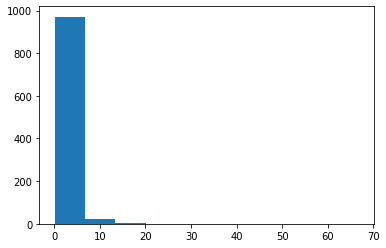

In [61]:
a = lognorm.rvs(s=1, scale=1, size=1000)
plt.hist(a)
plt.show()

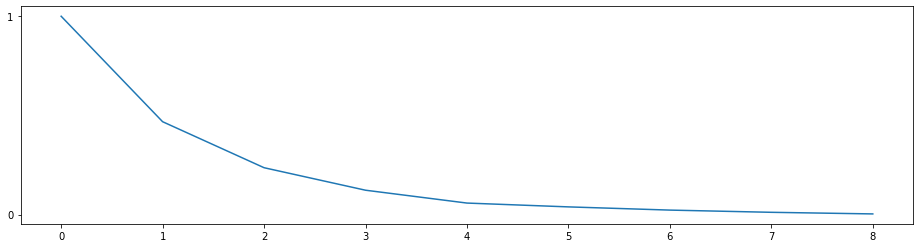

In [63]:
a = pd.DataFrame({"values": a}).clip(0, 10)
a["cut"] = pd.cut(a["values"], bins=range(0, 10))
freq = a["cut"].value_counts().sort_index(ascending=False)
sum_freq = freq.sum()
s = freq.cumsum() / sum_freq
s = s.sort_index()

plt.figure(figsize=(16, 4))
plt.yticks(range(0, 20))
plt.xticks(range(0, 10))
plt.plot(s.values)
plt.show()

In [64]:
s.index = list(range(9))
day_diff_to_importance_mapping = s.to_dict()
day_diff_to_importance_mapping

{0: 1.0,
 1: 0.46808510638297873,
 2: 0.23606889564336372,
 3: 0.12259371833839919,
 4: 0.057750759878419454,
 5: 0.03850050658561297,
 6: 0.022289766970618033,
 7: 0.011144883485309016,
 8: 0.00303951367781155}

In [67]:
important_events = {
    "Russia-Ukraine war": datetime(2022, 2, 24),
    "ban on woman rights rally": datetime(2022, 3, 8),
    "life imprisonment of Osman Kavala": datetime(2022, 4, 25),
    "zahko attack": datetime(2022, 7, 20),
    "anti-LGBT demonstration": datetime(2022, 9, 19),
    "new censorship law": datetime(2022, 10, 13),
    "police kills a turkish man": datetime(2023, 1, 8),
    "anniversary of coup attempt": datetime(2022, 7, 15),
}


def is_posted_during_an_important_event(time_created_at: datetime):
    importance_per_event = [
        day_diff_to_importance_mapping.get((time_created_at - event_date).days, 0)
        for event_date in important_events.values()
    ]
    return max(importance_per_event)


tweets_df_v15["posted_during_an_important_event"] = tweets_df_v15.created_at.apply(
    is_posted_during_an_important_event
)

In [68]:
tweets_df_v15['log_like_count'] = np.log(tweets_df_v15['like_count'] + 1)
tweets_df_v15['log_retweet_count'] = np.log(tweets_df_v15['retweet_count'] + 1)

In [69]:
tweets_df_v15.to_pickle("all_tweets_v15.pkl")